In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
import os

In [3]:
path = '/home/ikboljon.sobirov/data/fs1_research/Ikboljon.Sobirov/imagecas/imagecas/unzip_space/'
directories = os.listdir(path)
print(directories)

['1-200', '201-400', '401-600', '601-800', '801-1000']


In [4]:
training_data = []

for d in directories:
    # print(d)
    if '1-200' in d:
        for i in range(200):
            i += 1
            img_path = path + d + '/' + str(i) + '.img.nii.gz'
            label_path = path + d + '/' + str(i) + '.label.nii.gz'
            id_ = d + '/' + str(i)
            data = {"id": id_, "image": img_path, "label": label_path}
            training_data.append(data)

    elif '201-400' in d:
        for i in range(200):
            i += 201
            img_path = path + d + '/' + str(i) + '.img.nii.gz'
            label_path = path + d + '/' + str(i) + '.label.nii.gz'
            id_ = d + '/' + str(i)
            data = {"id": id_, "image": img_path, "label": label_path}
            training_data.append(data)
   
    elif '401-600' in d:
        for i in range(200):
            i += 401
            img_path = path + d + '/' + str(i) + '.img.nii.gz'
            label_path = path + d + '/' + str(i) + '.label.nii.gz'
            id_ = d + '/' + str(i)
            data = {"id": id_, "image": img_path, "label": label_path}
            training_data.append(data)
    
    elif '601-800' in d:
        for i in range(200):
            i += 601
            img_path = path + d + '/' + str(i) + '.img.nii.gz'
            label_path = path + d + '/' + str(i) + '.label.nii.gz'
            id_ = d + '/' + str(i)
            data = {"id": id_, "image": img_path, "label": label_path}
            training_data.append(data)
    
    elif '801-1000' in d:
        for i in range(200):
            i += 801
            img_path = path + d + '/' + str(i) + '.img.nii.gz'
            label_path = path + d + '/' + str(i) + '.label.nii.gz'
            id_ = d + '/' + str(i)
            data = {"id": id_, "image": img_path, "label": label_path}
            training_data.append(data)
    

### EDA

In [9]:
sample = training_data[3]
img = sitk.ReadImage(sample["image"])
label = sitk.ReadImage(sample["label"])

In [10]:
img.GetSize(), img.GetSpacing(), img.GetOrigin(), img.GetDirection()

((512, 512, 259),
 (0.341796875, 0.341796875, 0.5),
 (-56.3291015625, -66.1708984375, 423.95001220703125),
 (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0))

In [13]:
label.GetSize(), label.GetSpacing(), label.GetOrigin(), label.GetDirection()

((512, 512, 259),
 (0.341796875, 0.341796875, 0.5),
 (-56.3291015625, -66.1708984375, 423.95001220703125),
 (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0))

In [14]:
img_arr = sitk.GetArrayFromImage(img)
label_arr = sitk.GetArrayFromImage(label)


In [23]:
img_arr.min(), img_arr.max(), img_arr.mean(), img_arr.std()

(-1024, 1607, -143.8293757493892, 405.54750011796193)

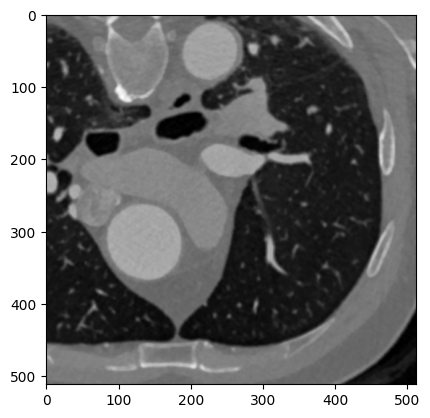

In [22]:
plt.imshow(img_arr[250,:,:], cmap='gray')

### Standartlashtirish

-- resampling
-- normalization

In [51]:
import SimpleITK as sitk

def resample_ct_image(image, new_spacing, interpolator=sitk.sitkLinear):
    # Get the original spacing
    original_spacing = image.GetSpacing()
    
    
    # Calculate the resampling factor
    resampling_factor = [original_spacing[i] / new_spacing[i] for i in range(3)]
    
    # Calculate the new size based on the resampling factor
    new_size = [int(image.GetSize()[i] * resampling_factor[i]) for i in range(3)]

    
    # Create the resampler
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetInterpolator(interpolator)
    resampler.SetOutputOrigin(image.GetOrigin())
    # Resample the image
    resampled_image = resampler.Execute(image)
    resampled_image.SetOrigin([0, 0, 0])
    
    return resampled_image


In [52]:
resampled_img = resample_ct_image(img, [1, 1, 1])
resampled_label = resample_ct_image(label, [1, 1, 1], interpolator=sitk.sitkNearestNeighbor)

In [49]:
resampled_img.GetSize(), resampled_img.GetSpacing(), resampled_img.GetOrigin(), resampled_img.GetDirection()

((175, 175, 129),
 (1.0, 1.0, 1.0),
 (0.0, 0.0, 0.0),
 (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0))

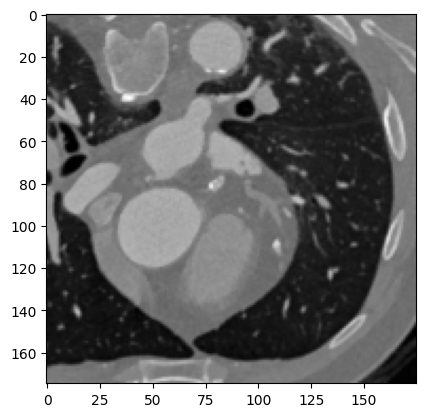

In [50]:
plt.imshow(sitk.GetArrayFromImage(resampled_img)[100,:,:], cmap='gray')

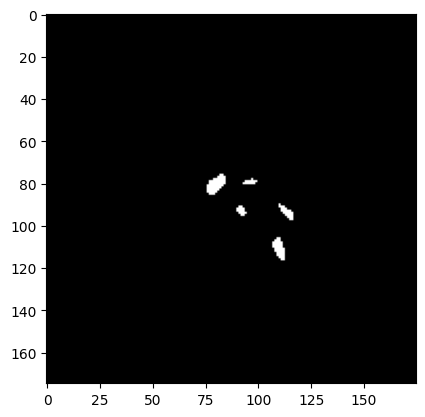

In [53]:
plt.imshow(sitk.GetArrayFromImage(resampled_label)[100,:,:], cmap='gray')

In [ ]:
sitk.WriteImage(resampled_img, 'resampled_img.nii.gz', True)

#### Normallashtirish

In [55]:
def clip_and_normalize_sitk_image(image, min_hu=-1024, max_hu=1024):
    """
    Clips the CT image to a specified range of Hounsfield Units (HU) and normalizes it to 0-1.

    Parameters:
        image (sitk.Image): The original CT image.
        min_hu (int): Minimum HU value for clipping.
        max_hu (int): Maximum HU value for clipping.

    Returns:
        sitk.Image: The processed image with HU values normalized between 0 and 1.
    """
    # Clip the image
    clipped_image = sitk.Clamp(image, sitk.sitkFloat32, min_hu, max_hu)
    
    # Normalize the image to range 0-1
    range_width = max_hu - min_hu
    normalized_image = (clipped_image - min_hu) / range_width

    return normalized_image

In [ ]:
# (img - min) / range

# (img - mean) / std

In [56]:
norm_ct = clip_and_normalize_sitk_image(resampled_img)

In [57]:
norm_ct_arr = sitk.GetArrayFromImage(norm_ct)
norm_ct_arr.min(), norm_ct_arr.max(), norm_ct_arr.mean(), norm_ct_arr.std()

(0.0, 1.0, 0.4300724626987423, 0.1972389754579293)

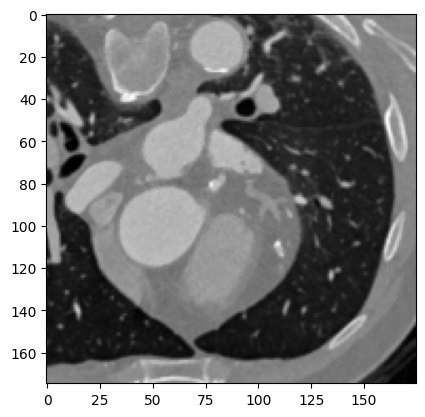

In [58]:
plt.imshow(norm_ct_arr[100,:,:], cmap='gray')

In [ ]:
# TODO`

# unarchive the dataset (kaggle)
# resample the dataset
# clip and normalize the dataset
# save the dataset

# format - path/patient_id/patieint_id_{img/seg}.nii.gz


# read the imagenet dataset paper (to be presented by Shokhrukh)